# PROJECT 1 - PART 1

## 0 - imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
import shap
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

## 1 - Q1 Exploratory Data Analysis

### 1.1 - loading data

In [2]:
df_train = pd.read_csv("datasets/heart_failure/train_val_split.csv")
df_test = pd.read_csv("datasets/heart_failure/test_split.csv")

#### NOTES AND OBSERVATIONS:
- AGE = age of the subjects, (29,77), peak 55 ca
- SEX = gender of the patient, M/F, mostly males
- CHEST PAIN TYPE = type of chest pain experienced by the patient, (ATA, ASY, NAP, TA), mostly ASY
--------------------------------------------------------------------------
med note: 
- ATA (Typical Angina):type of chest pain typically occurs when the heart is working harder than usual, considered a classic symptom of coronary artery disease (CAD)
- ASY (Atypical Angina): chest pain that doesn't fit the typical pattern of typical angina, still indicate underlying heart problems
- NAP (Non-Anginal Pain): chest discomfort or pain that is not related to angina or heart-related issues, not directly related to coronary artery disease
- TA (Asymptomatic): patient does not experience any chest pain
--------------------------------------------------------------------------
- RESTING BP = resting blood pressure of the patient, (should be under 120), however most of the data is above 120 -> higher RBP = increased risk of CHD, peaks (120,130,140)
- CHOLESTEROL = cholesterol level of the patient, (0,530), high cholesterol is a major risk factor for CHD, IDK ABOUT VALUES
- FASTING BS = amount of glucose in the bloodstream after fasting for at least 8 hours, (0 if <120 mg/dl, 1 if> 120 mg/dl), if 1 -> significant risk factor for CHD
- RESTING ECG = electrical activity of the heart while the patient is at rest, (normal, ST, LVH), ST segment changes = indicate risk of CHD
- MAX HR = maximum heart rate achieved by the patient, (60, 195), abnormal responses may indicate underlying heart disease, IDK ABOUT VALUES
- EXERCISE ANGINA = chest pain that occurs during physical activity, (N,Y), angina is a common symptom of CHD
- OLD PEAK = ST depression induced by exercise relative to rest, (-2, 6.2), ST depression during exercise stress testing is a common finding in patients with CHD, IDK ABOUT VALUES
- ST SLOPE = direction and angle of the ST segment on an electrocardiogram, (Up, Flat, Down), down ST slope is associated with CHD
- HEART DISEASE = blood vessel diameter narrowing, (0 = < 50%, 1 = > 50%), 1 = CHD

### 1.2 - dataset exploration

In [3]:
# 0 - dimensions
print(f"Number of samples: {df_train.shape[0]:,.0f}")
print(f"Number of features: {df_train.shape[1]}")
print("--------------------------------------------------------------------------------")

# 1 - general info
df_train.info()
print("--------------------------------------------------------------------------------")

# 2 - look at some samples
df_train.head(5)

Number of samples: 734
Number of features: 12
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
 11  HeartDisease    734 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 68.9+ KB
---------------------------------------------------------------------------

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


### 1.3 - numerical features

In [4]:
# 0 - general informations
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,734.0,53.523161,9.421110,29.0,47.00,54.0,60.0,77.0
RestingBP,734.0,132.062670,18.618490,0.0,120.00,130.0,140.0,200.0
Cholesterol,734.0,197.588556,108.979439,0.0,172.25,222.0,267.0,529.0
FastingBS,734.0,0.232970,0.423012,0.0,0.00,0.0,0.0,1.0
MaxHR,734.0,136.167575,25.334552,60.0,120.00,138.0,155.0,195.0
Oldpeak,734.0,0.873978,1.082222,-2.0,0.00,0.5,1.5,6.2
HeartDisease,734.0,0.542234,0.498553,0.0,0.00,1.0,1.0,1.0


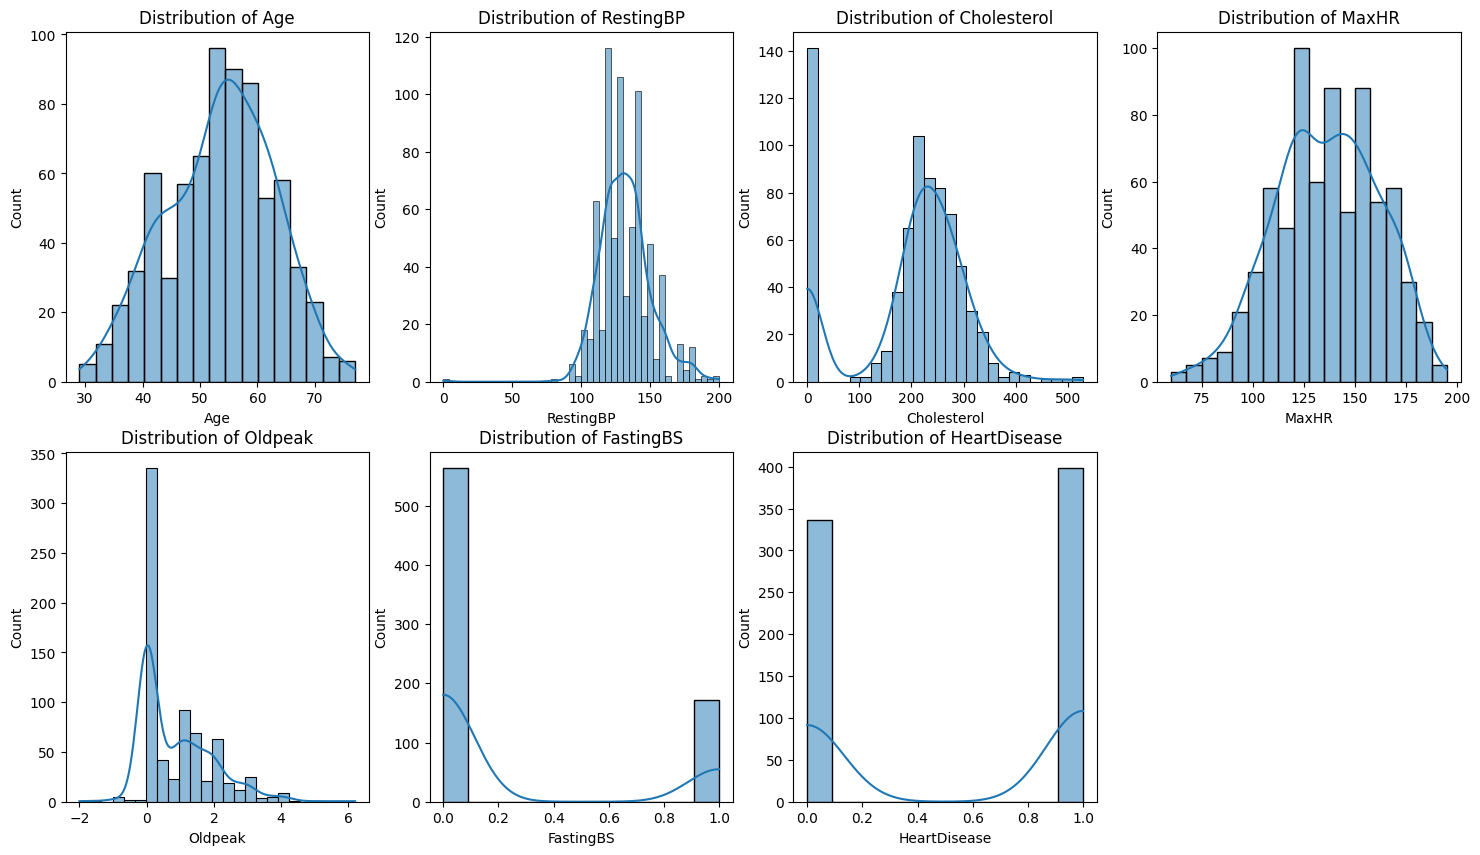

In [5]:
# 1 - data distributions
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
numerical_features = ['Age', 'RestingBP', 'Cholesterol','MaxHR', 'Oldpeak', 'FastingBS', 'HeartDisease']
for i, feature in enumerate(numerical_features, start=0):
    sb.histplot(data=df_train, x=feature, ax=axes[i // 4, i % 4], kde=True)
    axes[i // 4, i % 4].set_title(f'Distribution of {feature}')
fig.delaxes(axes[1, 3])

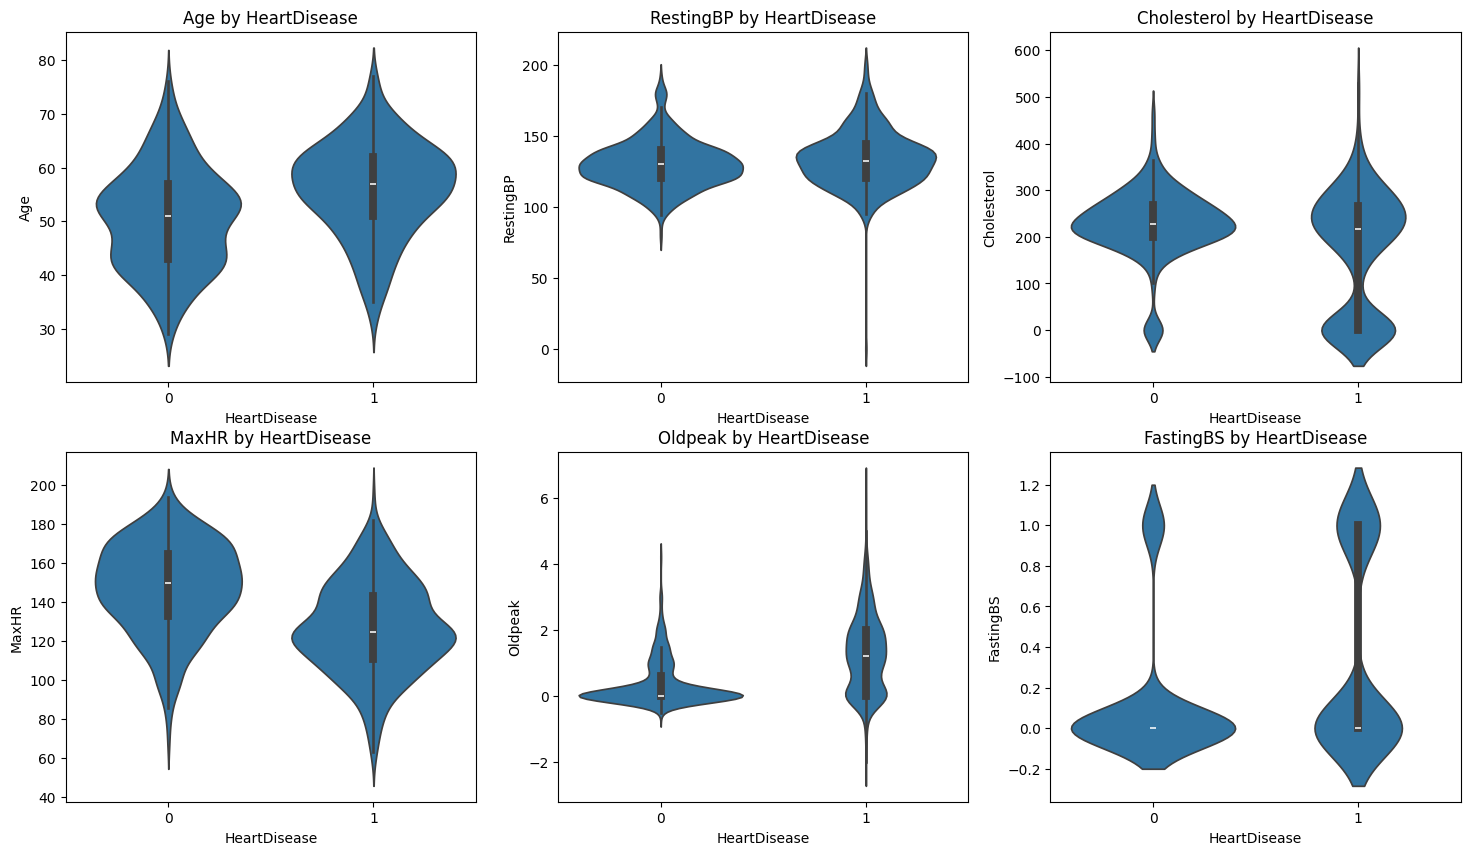

In [6]:
# 2 - features' relationship with heart disease
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
features = ['Age', 'RestingBP', 'Cholesterol','MaxHR', 'Oldpeak', 'FastingBS']
for i, feature in enumerate(features, start=0):
    sb.violinplot(data=df_train, x='HeartDisease', y=feature, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'{feature} by HeartDisease')

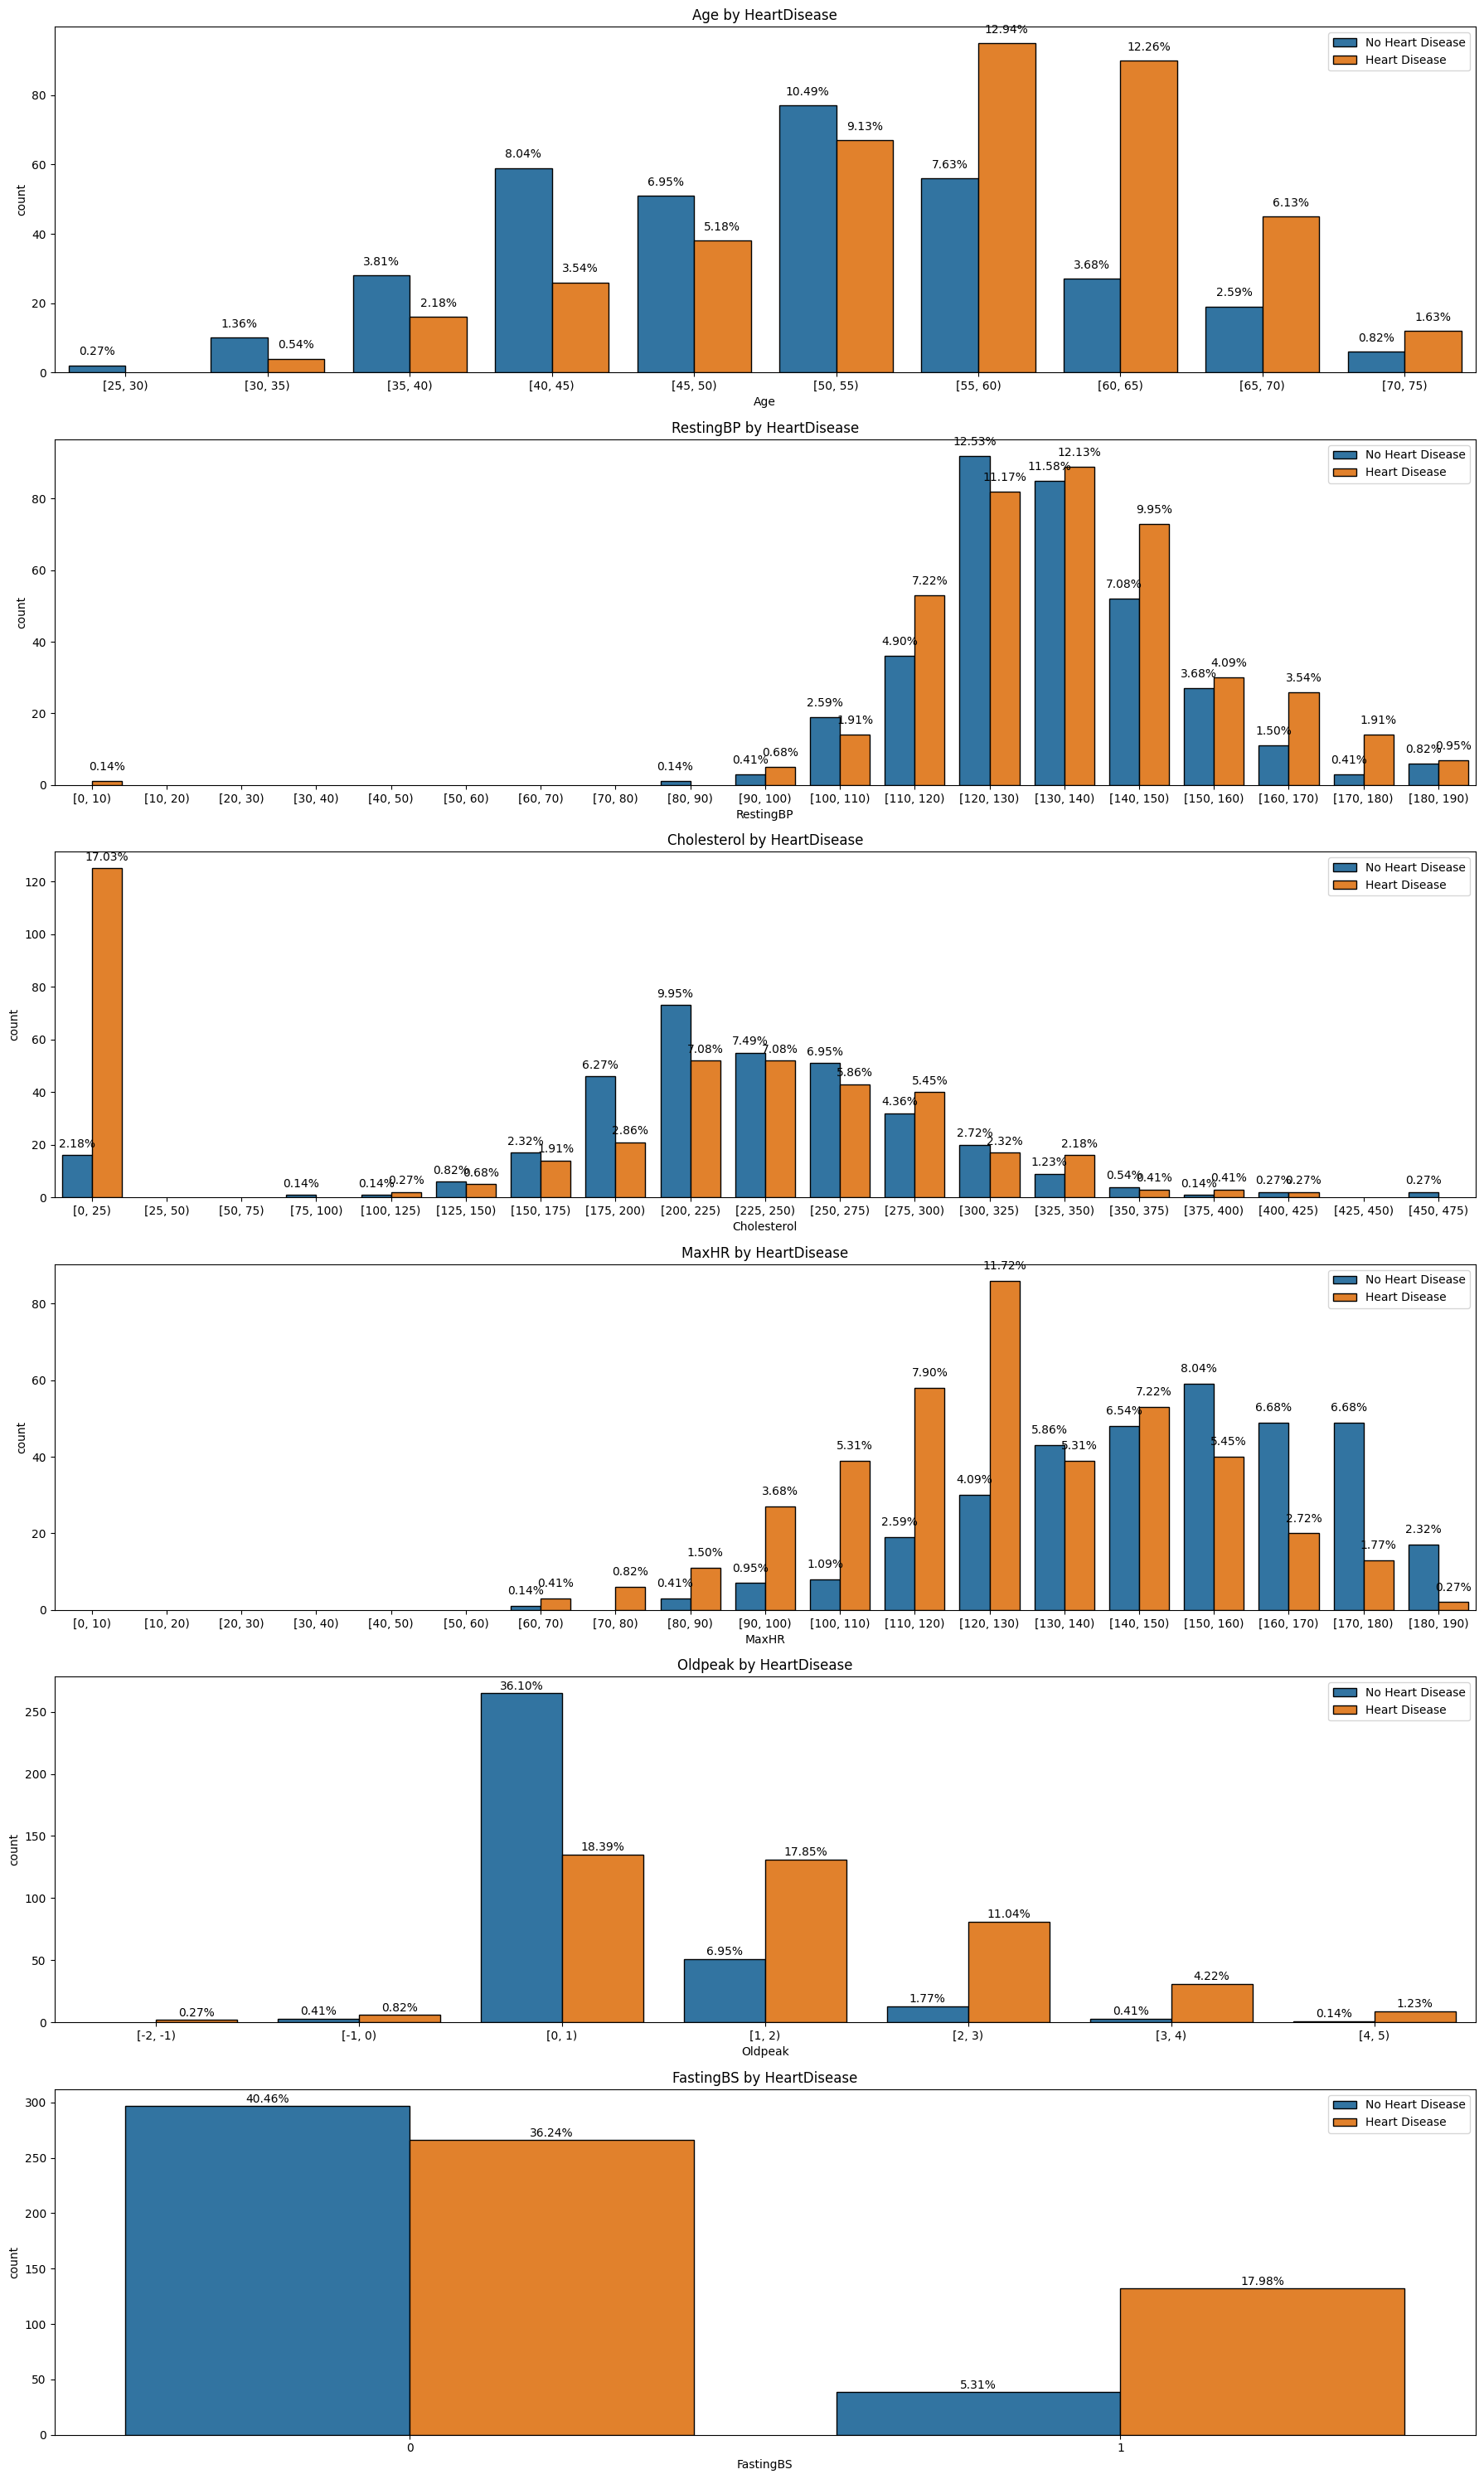

In [7]:
# 3 - features' relationship with heart disease (MORE READABLE)
data = pd.read_csv("datasets/heart_failure/train_val_split.csv")

for col in data.select_dtypes(include=['int64', 'float64']).columns:
    if col=='Age':
        data[col] = pd.cut(data[col], bins=range(25, 80, 5), right=False)
    if col=='RestingBP' or col=='MaxHR':
        data[col] = pd.cut(data[col], bins=range(0, 200, 10), right=False)
    if col=='Cholesterol':
        data[col] = pd.cut(data[col], bins=range(0, 500, 25), right=False)
    if col=='Oldpeak':
        data[col] = pd.cut(data[col], bins=range(-2, 6, 1), right=False)

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(18, 30))
for i, feature in enumerate(features, start=0):
    row = i % 6
    ax = sb.countplot(x=feature, data=data, hue='HeartDisease', edgecolor='black', ax=axes[row])
    axes[row].legend(['No Heart Disease', 'Heart Disease'])
    axes[row].set_title(f'{feature} by HeartDisease')
    total = float(len(df_train))
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Avoid plotting text on non-existent bars
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 3,
                    '{:.2f}%'.format((height / total) * 100),
                    ha="center")
plt.tight_layout()
plt.show()

### 1.4 - categorical features

In [8]:
# 0 - general informations
df_train.describe(include="object").T

,count,unique,top,freq
Sex,734,2,M,573
ChestPainType,734,4,ASY,381
RestingECG,734,3,Normal,440
ExerciseAngina,734,2,N,439
ST_Slope,734,3,Flat,364


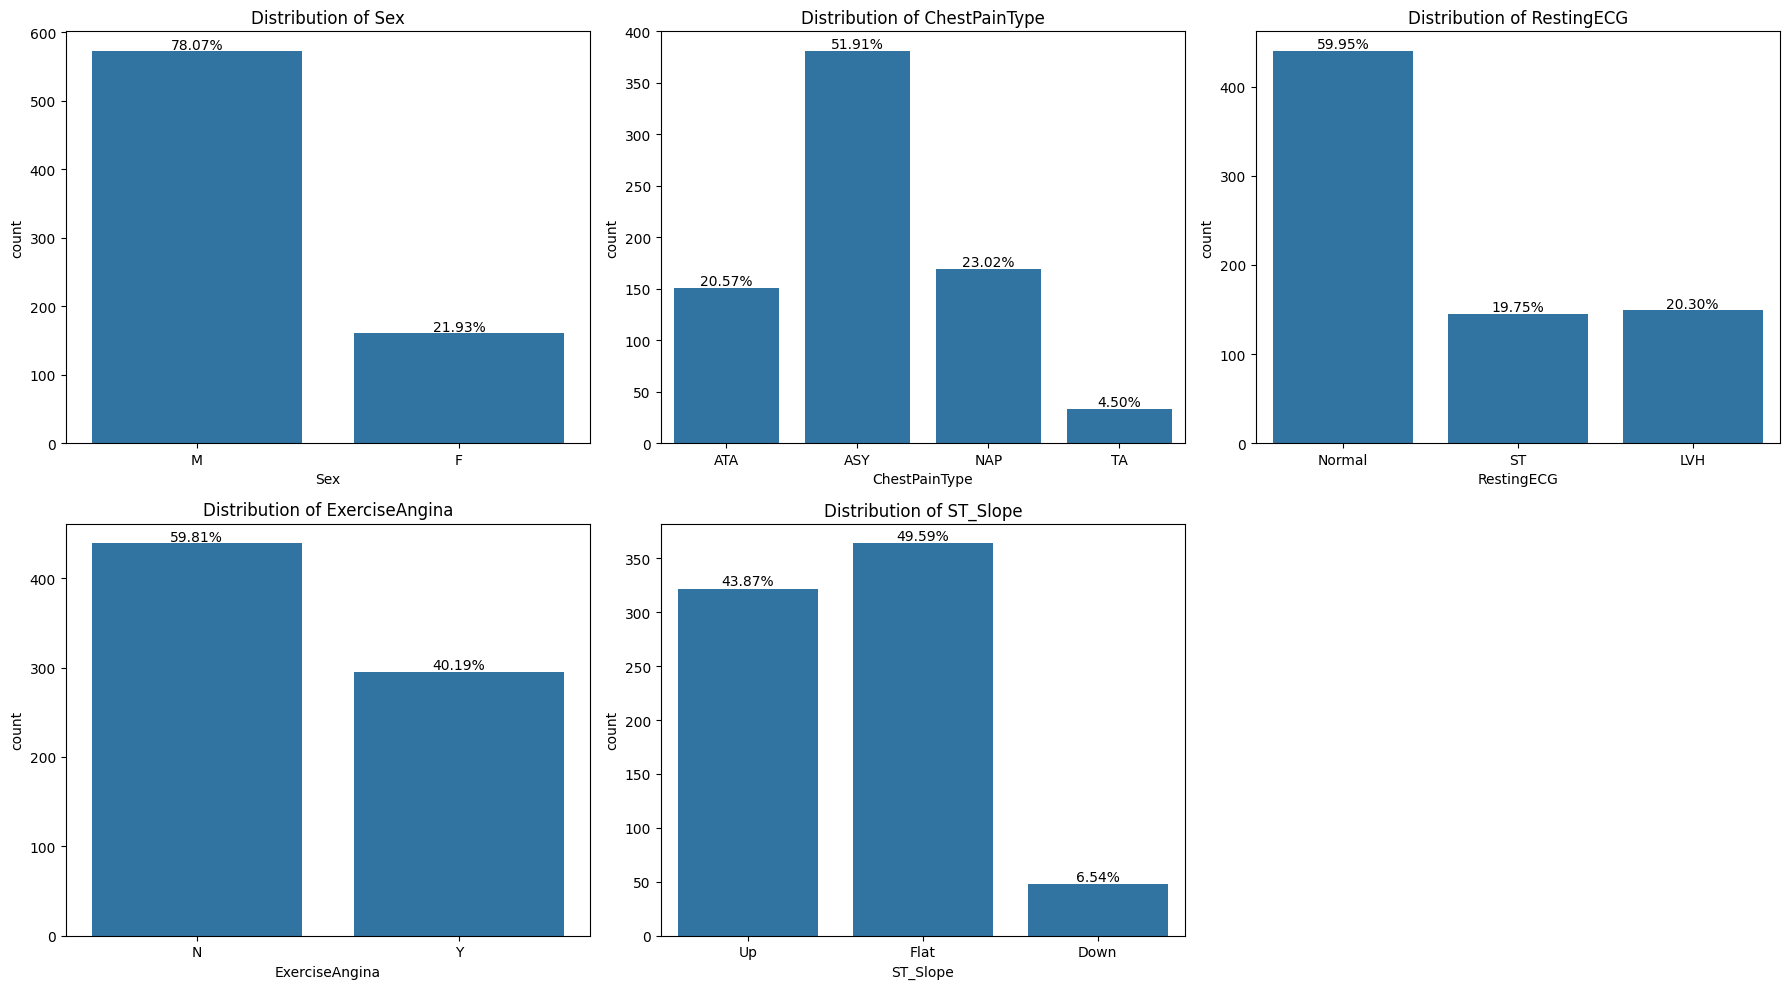

In [9]:
# 1 - feature distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for i, feature in enumerate(categorical_features, start=0):
    ax = sb.countplot(data=df_train, x=feature, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'Distribution of {feature}')

    # Add percentage for each column
    total = float(len(df_train))
    for p in ax.patches:
        height = p.get_height()
        if height > 0: 
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 3,
                    '{:.2f}%'.format((height / total) * 100),
                    ha="center")
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


In [10]:
#table view
percentages = {}
total_samples = len(df_train)
for feature in categorical_features:
    feature_percentages = {}
    for category in df_train[feature].unique():
        count = len(df_train[df_train[feature] == category])
        percentage = (count / total_samples) * 100
        feature_percentages[category] = f'{percentage:.2f}%'
    percentages[feature] = feature_percentages
percentages_df = pd.DataFrame(percentages)
print(percentages_df.T)


                     M       F     ATA     ASY     NAP     TA  Normal      ST  \
Sex             78.07%  21.93%     NaN     NaN     NaN    NaN     NaN     NaN   
ChestPainType      NaN     NaN  20.57%  51.91%  23.02%  4.50%     NaN     NaN   
RestingECG         NaN     NaN     NaN     NaN     NaN    NaN  59.95%  19.75%   
ExerciseAngina     NaN     NaN     NaN     NaN     NaN    NaN     NaN     NaN   
ST_Slope           NaN     NaN     NaN     NaN     NaN    NaN     NaN     NaN   

                   LVH       N       Y      Up    Flat   Down  
Sex                NaN     NaN     NaN     NaN     NaN    NaN  
ChestPainType      NaN     NaN     NaN     NaN     NaN    NaN  
RestingECG      20.30%     NaN     NaN     NaN     NaN    NaN  
ExerciseAngina     NaN  59.81%  40.19%     NaN     NaN    NaN  
ST_Slope           NaN     NaN     NaN  43.87%  49.59%  6.54%  


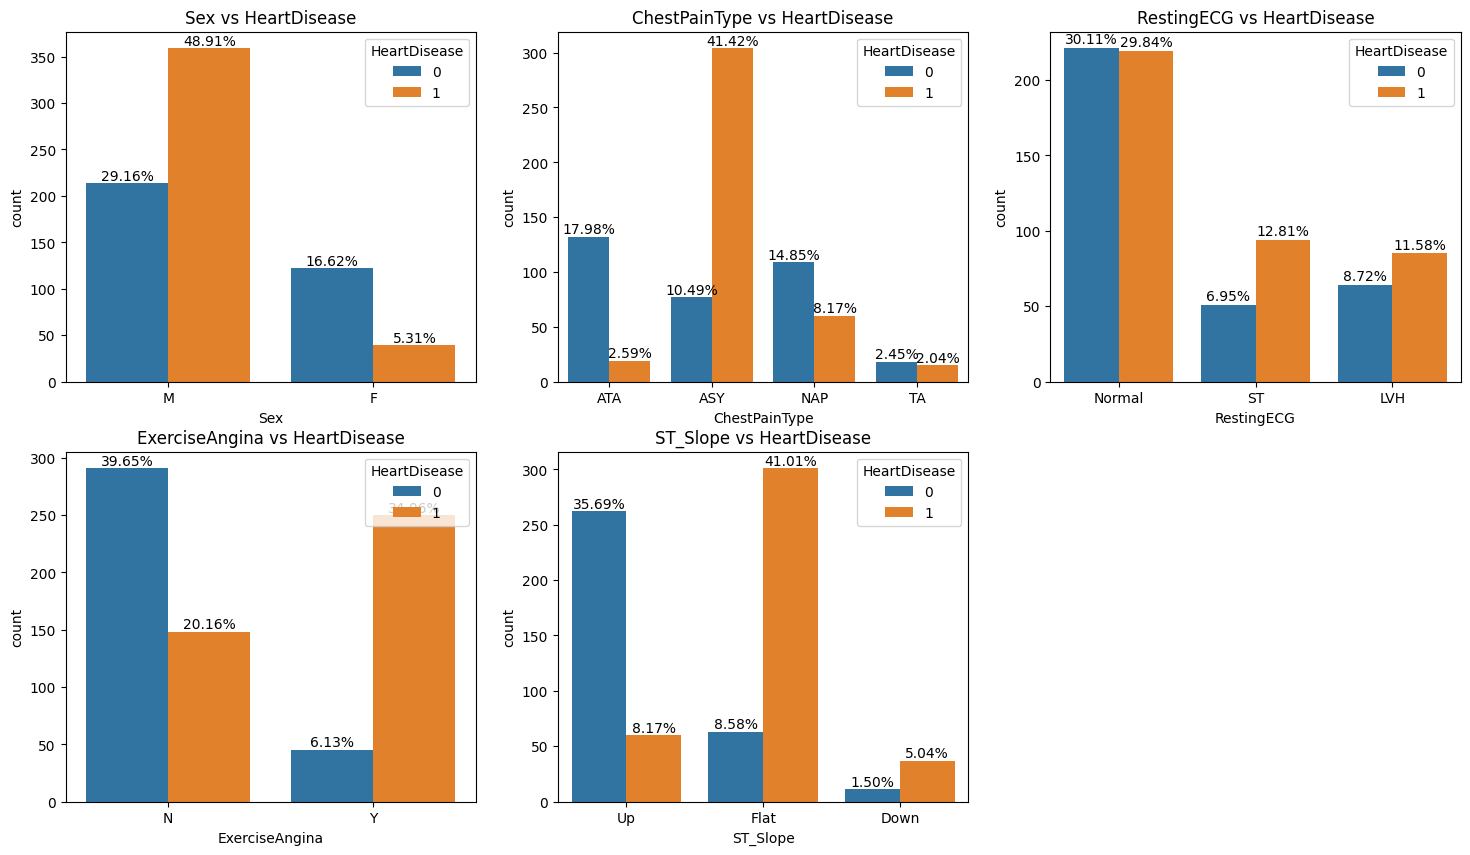

In [11]:
# 2 - features' relationship with heartdisease
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# categorical features
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for i, feature in enumerate(categorical_features, start=0):
    ax = sb.countplot(data=df_train, x=feature, hue='HeartDisease', ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'{feature} vs HeartDisease')
    axes[i // 3, i % 3].legend(title='HeartDisease', loc='upper right')
# Add percentage for each column
    total = float(len(df_train))
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Avoid plotting text on non-existent bars
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 3,
                    '{:.2f}%'.format((height / total) * 100),
                    ha="center")
fig.delaxes(axes[1, 2])

### 1.5 - check for null values

In [12]:
#number of null values for each feature
df_train.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### 1.6 - dataset balance

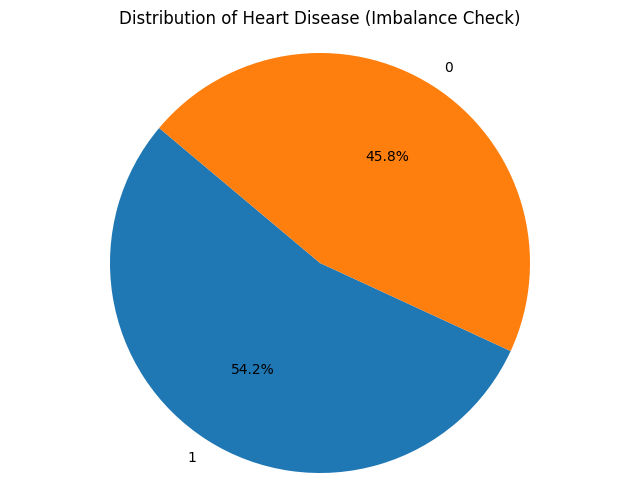

In [13]:
heart_disease_counts = df_train['HeartDisease'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(heart_disease_counts, labels=heart_disease_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Heart Disease (Imbalance Check)')
plt.axis('equal')
plt.show()

### 1.7 - categorical data encoding

In [14]:
encoded_mapping = {}
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label_encoder = LabelEncoder()
for col in categorical_features:
    df_train[col]=label_encoder.fit_transform(df_train[col])
    df_test[col]=label_encoder.transform(df_test[col])
encoded_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(encoded_mapping)

{'ST_Slope': {'Down': 0, 'Flat': 1, 'Up': 2}}


### 1.8 - data preprocessing

In [15]:
mms = MinMaxScaler()
ss = StandardScaler()
rs = RobustScaler()

df_train['Oldpeak'] = mms.fit_transform(df_train[['Oldpeak']])
df_test['Oldpeak'] = mms.transform(df_test[['Oldpeak']])

df_train['Age'] = ss.fit_transform(df_train[['Age']])
df_test['Age'] = ss.transform(df_test[['Age']])

df_train['RestingBP'] = ss.fit_transform(df_train[['RestingBP']])
df_test['RestingBP'] = ss.transform(df_test[['RestingBP']])

df_train['Cholesterol'] = rs.fit_transform(df_train[['Cholesterol']])
df_test['Cholesterol'] = rs.transform(df_test[['Cholesterol']])

df_train['MaxHR'] = ss.fit_transform(df_train[['MaxHR']])
df_test['MaxHR'] = ss.fit_transform(df_test[['MaxHR']])

### 1.9 - features correltion with target

ST_Slope          0.568581
ExerciseAngina    0.502205
Oldpeak           0.420891
MaxHR             0.405552
ChestPainType     0.390924
Sex               0.319183
Age               0.294751
FastingBS         0.254086
Cholesterol       0.253538
RestingBP         0.101420
RestingECG        0.048260
Name: HeartDisease, dtype: float64


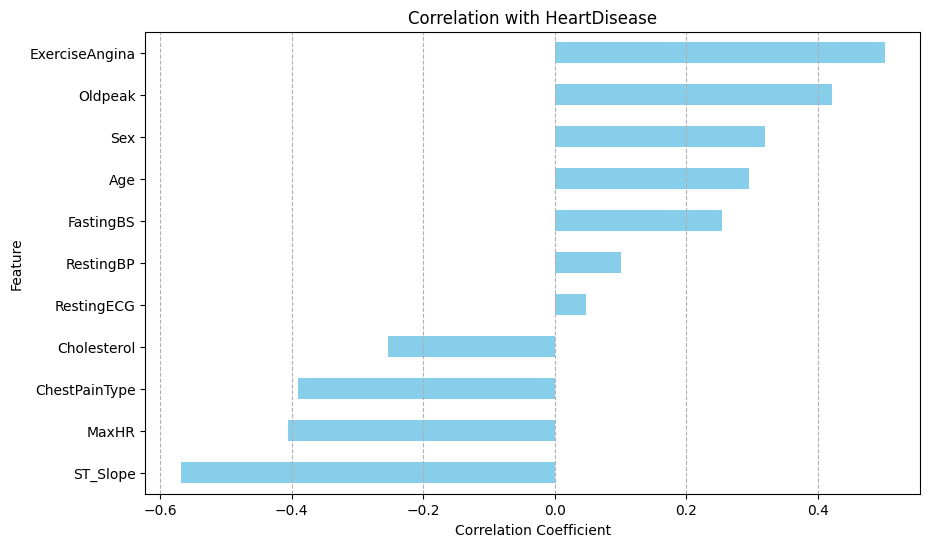

In [16]:
correlation = df_train.corr()['HeartDisease'].drop('HeartDisease')
abs_correlation = correlation.abs().sort_values(ascending=False)
print(abs_correlation)
# plot version
plt.figure(figsize=(10, 6))
correlation.sort_values().plot(kind='barh', color='skyblue')
plt.title('Correlation with HeartDisease')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=1)
plt.show()

## 2 - Q2 Lasso regression

#### 2.1 - dataset splitting

In [17]:
# split dataset
X_train = df_train.drop(columns=['HeartDisease'])
y_train = df_train['HeartDisease']
X_test = df_test.drop(columns=['HeartDisease'])
y_test = df_test['HeartDisease']

### 2.2 - lasso regression

In [18]:
# 0 - find best alpha with cross validation
lasso_cv = LassoCV(cv=7)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.alpha_
print('best alpha = ', best_alpha)

# 1 - fit
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)

train_score = lasso.score(X_train, y_train)
test_score = lasso.score(X_test, y_test)

print("train R^2 Score:", train_score)
print("test R^2 Score:", test_score)

# 2 - move prediction to 0,1
y_pred = lasso.predict(X_test)
binary_predictions = np.where(y_pred >= 0.5, 1, 0)

# 3 - compute F1-score
f1 = f1_score(y_test, binary_predictions)
print("F1-score:", f1)

best alpha =  0.00020205117951440908
train R^2 Score: 0.5327635229079208
test R^2 Score: 0.42451072137407997
F1-score: 0.8699551569506726


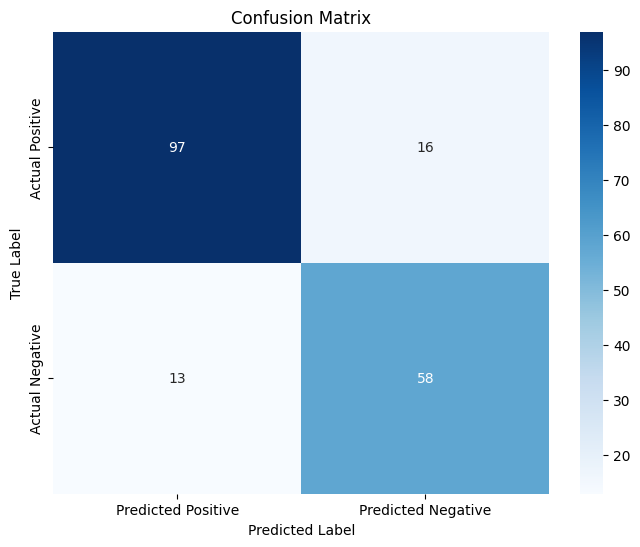

In [19]:
# f1 score visualization
tn, fp, fn, tp = confusion_matrix(y_test, binary_predictions).ravel()

conf_matrix = np.array([[tp, fp],
                        [fn, tn]])
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 2.3 - feature coefficients

In [20]:
# coeff
coefficients = lasso.coef_
coefficients_df = pd.DataFrame({'Feature': X_test.columns, 'Coefficient': coefficients})
#sort by impirtance
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)
print(coefficients_df)

           Feature  Coefficient
9          Oldpeak     0.470307
10        ST_Slope    -0.238022
8   ExerciseAngina     0.186690
1              Sex     0.182475
5        FastingBS     0.131207
2    ChestPainType    -0.094069
4      Cholesterol    -0.051375
7            MaxHR    -0.035874
0              Age     0.030119
6       RestingECG    -0.020239
3        RestingBP     0.003725


#### NOTES AND OBSERVATIONS:
- I noticed that if I discard Oldpeak<0 -> train and test have similar values
- big difference with >0 or not

## 3 - Q3 MLP + SHAP

### 3.1 - data preprocessing (same as before BUT no changes to HD)

In [21]:
# 1 - data, importing the data
df_train = pd.read_csv("datasets/heart_failure/train_val_split.csv")
df_test = pd.read_csv("datasets/heart_failure/test_split.csv")

# 2 - encode categorical data -> we use a label encoder
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label_encoder = LabelEncoder()
for col in categorical_features:
    df_train[col]=label_encoder.fit_transform(df_train[col])
    df_test[col]=label_encoder.transform(df_test[col])

# 3 - scaling, robust scaler removes the median and scales the data according to the quantile range,  robust to ouliers
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
feat_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('all', feat_transformer, numerical_features + categorical_features)
    ]
)
train_preprocessed_raw = preprocessor.fit_transform(df_train)
test_preprocessed_raw = preprocessor.transform(df_test)


# 5 - back into df shape
processed_columns = numerical_features + categorical_features
train_preprocessed = pd.DataFrame(train_preprocessed_raw, columns=processed_columns)
test_preprocessed = pd.DataFrame(test_preprocessed_raw, columns=processed_columns)


# 6 - split X,y
X_train = train_preprocessed
y_train = df_train['HeartDisease'].reset_index(drop=True)
X_test = test_preprocessed
y_test = df_test['HeartDisease'].reset_index(drop=True)
#print(X_test)

### 3.2 - MLP

In [22]:
#we create a simple MLP classifier and train it on the training dataset.
mlp = MLPClassifier(activation='relu',hidden_layer_sizes=(20,),solver='adam',max_iter=300,random_state=25)
mlp.fit(X_train, y_train)
print(mlp.score(X_test, y_test))

0.8260869565217391


/home/ilboglions/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### 3.3 - SHAP

#### SHAP split by class

In [23]:
# 1 - SHAP values
explainer = shap.KernelExplainer(mlp.predict, X_train)
shap_values = explainer(X_test)
y_pred = mlp.predict(X_test)


Using 734 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/184 [00:00<?, ?it/s]

In [24]:
# 2 - pick 2 positive and 2 negative samples
y_test_df = pd.DataFrame(y_test)
y_test_df["Pred"] = y_pred
positive_samples_index = np.array(y_test_df.loc[y_test_df["HeartDisease"].eq(1) & y_test_df["Pred"].eq(1)].index[:2])
negative_samples_index = np.array(y_test_df.loc[y_test_df["HeartDisease"].eq(0) & y_test_df["Pred"].eq(0)].index[:2])

##### positive samples plots

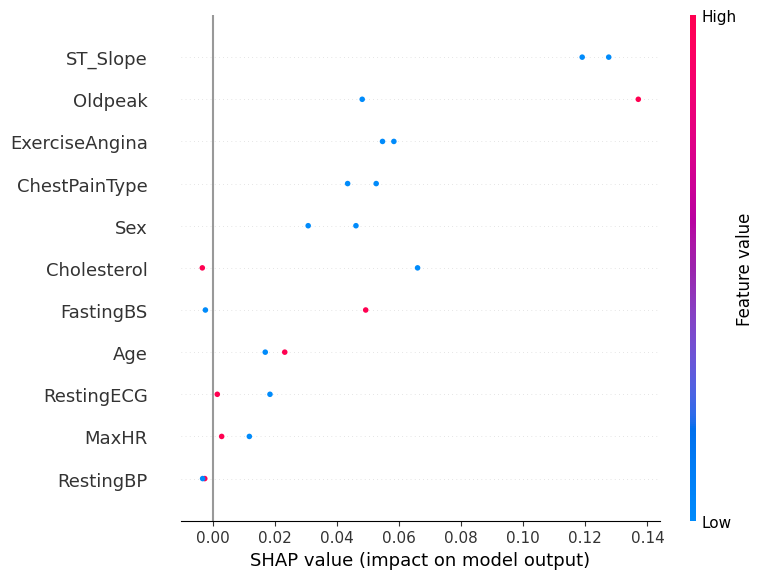

In [25]:
#Summary plot of the positive samples values. For all these plots on the x axis we have the impact
#Of the variable on the model output, a positive SHAP value means that that variable has a positive impact on the prediction (towards positive)
# On the other hand a negative value means that that variable has a negative impact (towards negative prediction)
shap.summary_plot(shap_values[positive_samples_index],X_test.iloc[positive_samples_index],feature_names=X_train.columns.values)

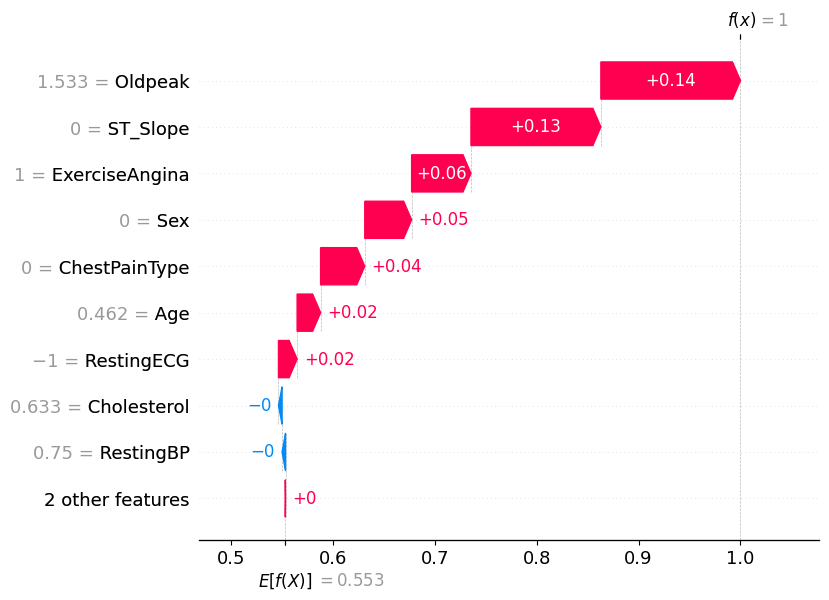

In [26]:
shap.plots.waterfall(shap_values[positive_samples_index[0]], max_display=10)

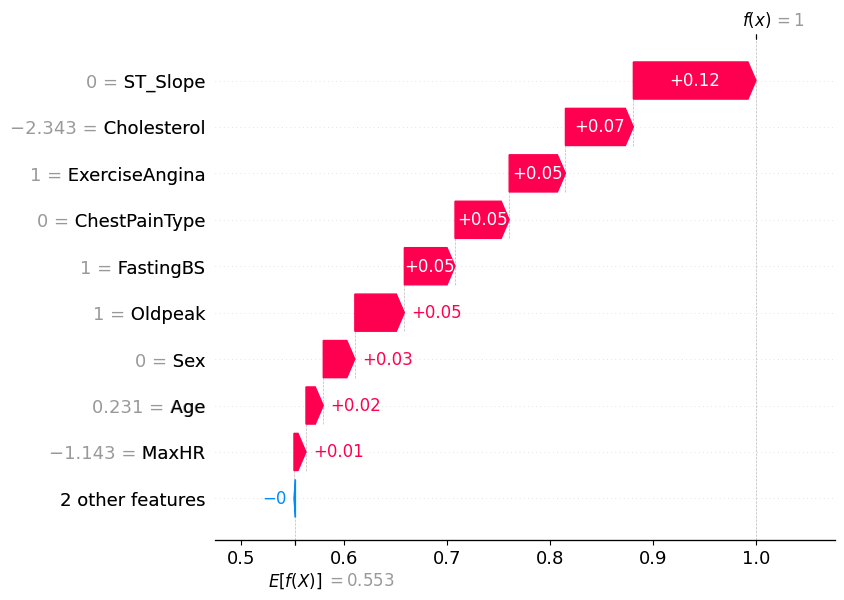

In [27]:
shap.plots.waterfall(shap_values[positive_samples_index[1]], max_display=10)

##### negative samples plots

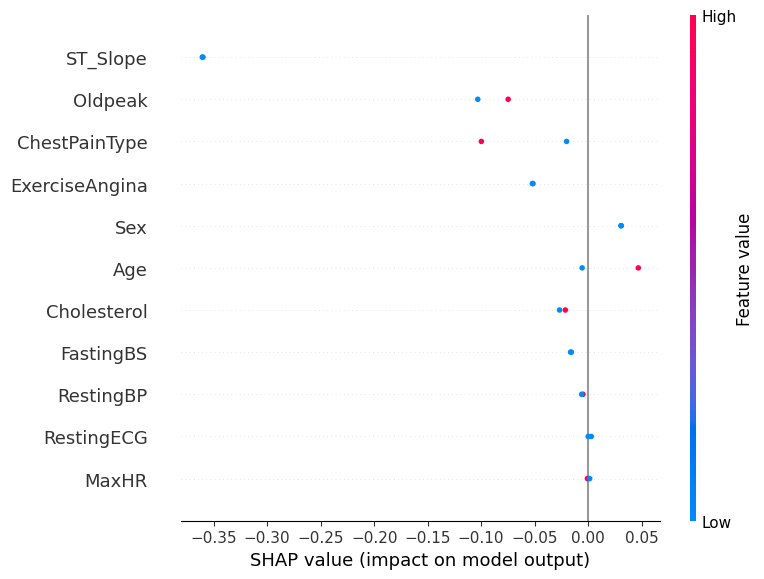

In [28]:
shap.summary_plot(shap_values[negative_samples_index],X_test.iloc[negative_samples_index],feature_names=X_train.columns.values)

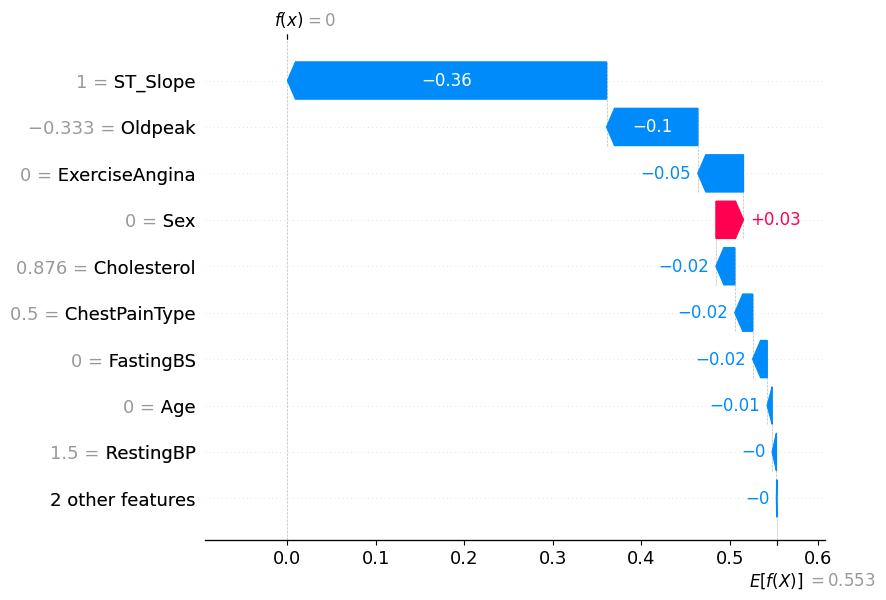

In [29]:
shap.plots.waterfall(shap_values[negative_samples_index[0]], max_display=10)

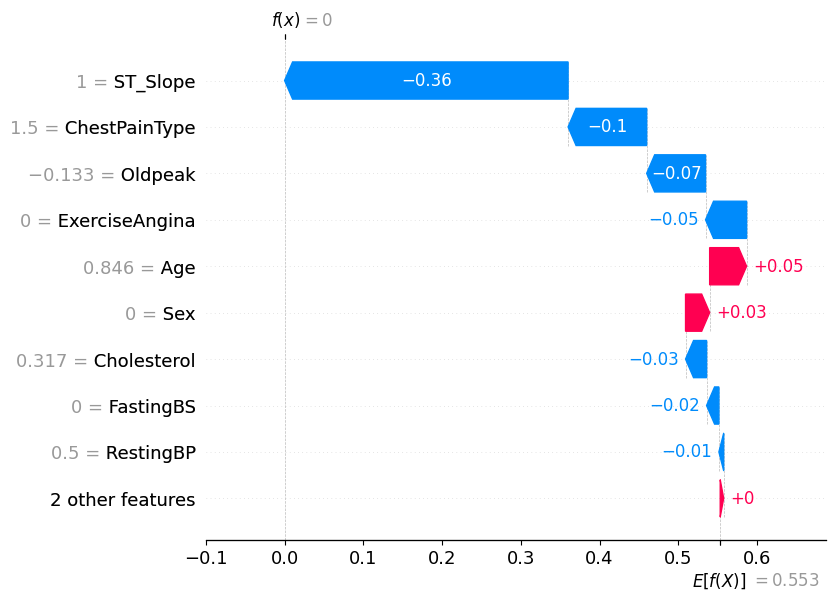

In [30]:
shap.plots.waterfall(shap_values[negative_samples_index[1]], max_display=10)

#### SHAP on all data

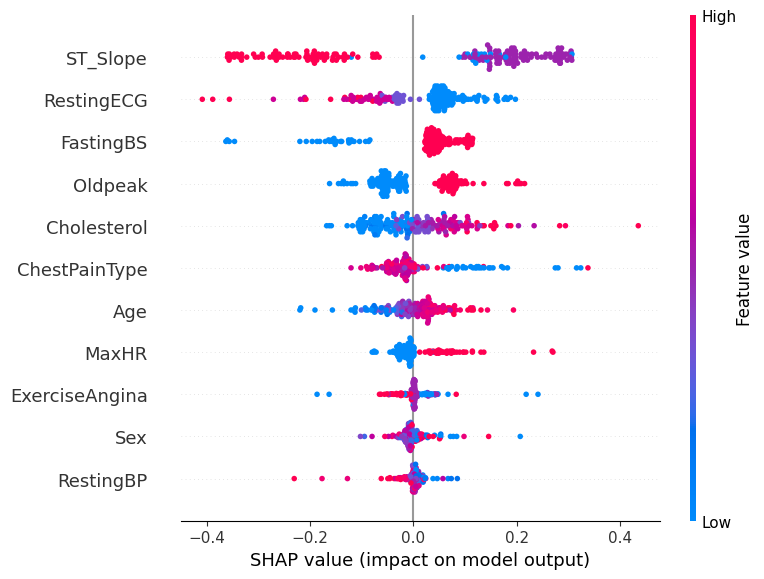

In [31]:
shap.summary_plot(shap_values,X_test,feature_names=df_train.columns.values)

## 4 - Q4 NAM

### 4.1 - moving to pytorch

In [44]:
# 1 - df to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 2 - dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

torch.Size([734, 11])


### 4.2 - model

In [68]:
class FeatureNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(1, 64)
        self.l2 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        out = self.l4(x)
        return out

class NAM(nn.Module):
    def __init__(self, num_features, link_func="sigmoid"):
        super().__init__()
        self.networks = nn.ModuleList([FeatureNetwork() for _ in range(num_features)])
        self.num_features = num_features
        self.bias = nn.Parameter(torch.rand(1))
        self.link_func = link_func

    def forward(self, x):
        B, dim = x.shape
        outs = torch.zeros(B, dim)
        
        for i in range(B):
            for j in range(self.num_features):
                net = self.networks[j]
                xi = x[i, j].unsqueeze(dim=0)
                outs[i, j] = net(xi)

        summed = outs.sum(axis=1) + self.bias

        res = torch.sigmoid(summed).view(B, 1)

        return res
    def explain(self, x):
        B, dim = x.shape
        outs = torch.zeros(B, dim)
        
        for i in range(B):
            print("New Sample")
            for j in range(self.num_features):
                net = self.networks[j]
                xi = x[i, j].unsqueeze(dim=0)
                outs[i, j] = net(xi)
            normalizer = outs[i].abs().sum().item()
            for j in range(self.num_features):
                print(f"Feature {X_train.columns.values[j]}: Importance {(outs[i,j]/normalizer).item()}")



model = NAM(X_train.shape[1])

I took away 2 layers and it seems better + simpler model performs better

### 4.3 - training

In [34]:
# 0 - loss + optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 1 - training
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 2 - evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = (outputs >= 0.5).squeeze().cpu().numpy()
    accuracy = (predictions == y_test).mean()

print(f"Accuracy: {accuracy}")

Epoch [10/150], Loss: 0.2956
Epoch [20/150], Loss: 0.1598
Epoch [30/150], Loss: 0.2505
Epoch [40/150], Loss: 0.3900
Epoch [50/150], Loss: 0.1730
Epoch [60/150], Loss: 0.2803
Epoch [70/150], Loss: 0.4108
Epoch [80/150], Loss: 0.2878
Epoch [90/150], Loss: 0.1632
Epoch [100/150], Loss: 0.3727
Epoch [110/150], Loss: 0.1242
Epoch [120/150], Loss: 0.4956
Epoch [130/150], Loss: 0.2386
Epoch [140/150], Loss: 0.1658
Epoch [150/150], Loss: 0.3933
Accuracy: 0.8260869565217391


In [69]:
model.explain(torch.tensor(X_test.iloc[positive_samples_index].values, dtype=torch.float32))

New Sample
Feature Age: Importance 0.06688845157623291
Feature RestingBP: Importance 0.3109455108642578
Feature Cholesterol: Importance -0.012940982356667519
Feature MaxHR: Importance -0.06582319736480713
Feature Oldpeak: Importance 0.2672935426235199
Feature Sex: Importance 0.024394147098064423
Feature ChestPainType: Importance -0.03989768028259277
Feature FastingBS: Importance 0.08334502577781677
Feature RestingECG: Importance -0.053281527012586594
Feature ExerciseAngina: Importance 0.04785853996872902
Feature ST_Slope: Importance -0.02733144909143448
New Sample
Feature Age: Importance 0.05738960951566696
Feature RestingBP: Importance 0.34790539741516113
Feature Cholesterol: Importance 0.202532559633255
Feature MaxHR: Importance 0.05631643533706665
Feature Oldpeak: Importance 0.18449196219444275
Feature Sex: Importance 0.018712036311626434
Feature ChestPainType: Importance -0.030604341998696327
Feature FastingBS: Importance -0.038278963416814804
Feature RestingECG: Importance -0.0060

In [70]:
model.explain(torch.tensor(X_test.iloc[negative_samples_index].values, dtype=torch.float32))

New Sample
Feature Age: Importance 0.08537635207176208
Feature RestingBP: Importance 0.5483570098876953
Feature Cholesterol: Importance -0.01689167693257332
Feature MaxHR: Importance -0.048234280198812485
Feature Oldpeak: Importance 0.04584901034832001
Feature Sex: Importance 0.029493296518921852
Feature ChestPainType: Importance -0.06333893537521362
Feature FastingBS: Importance 0.10076677054166794
Feature RestingECG: Importance -0.009603044018149376
Feature ExerciseAngina: Importance 0.024832461029291153
Feature ST_Slope: Importance 0.02725711651146412
New Sample
Feature Age: Importance 0.030508650466799736
Feature RestingBP: Importance 0.3689727485179901
Feature Cholesterol: Importance -0.024173246696591377
Feature MaxHR: Importance -0.084934301674366
Feature Oldpeak: Importance 0.08276159316301346
Feature Sex: Importance 0.0316748209297657
Feature ChestPainType: Importance -0.20249861478805542
Feature FastingBS: Importance 0.1082201600074768
Feature RestingECG: Importance -0.010313